# **Using neural network to solve ODE**

**Example 1:** Solve the following ODE:
$$y'(x)=-2xy(x), \quad y(0)=1.$$
The exact solution is $y(x)=e^{-x^2}$

**Method:** We will try to optimize a loss function to force it match where the loss function is defined by the equation and the initial condition(s). The model is adapted from the deep network model.<br>
In this example we use 1 hidden fully connected hidden layer(size 10) network

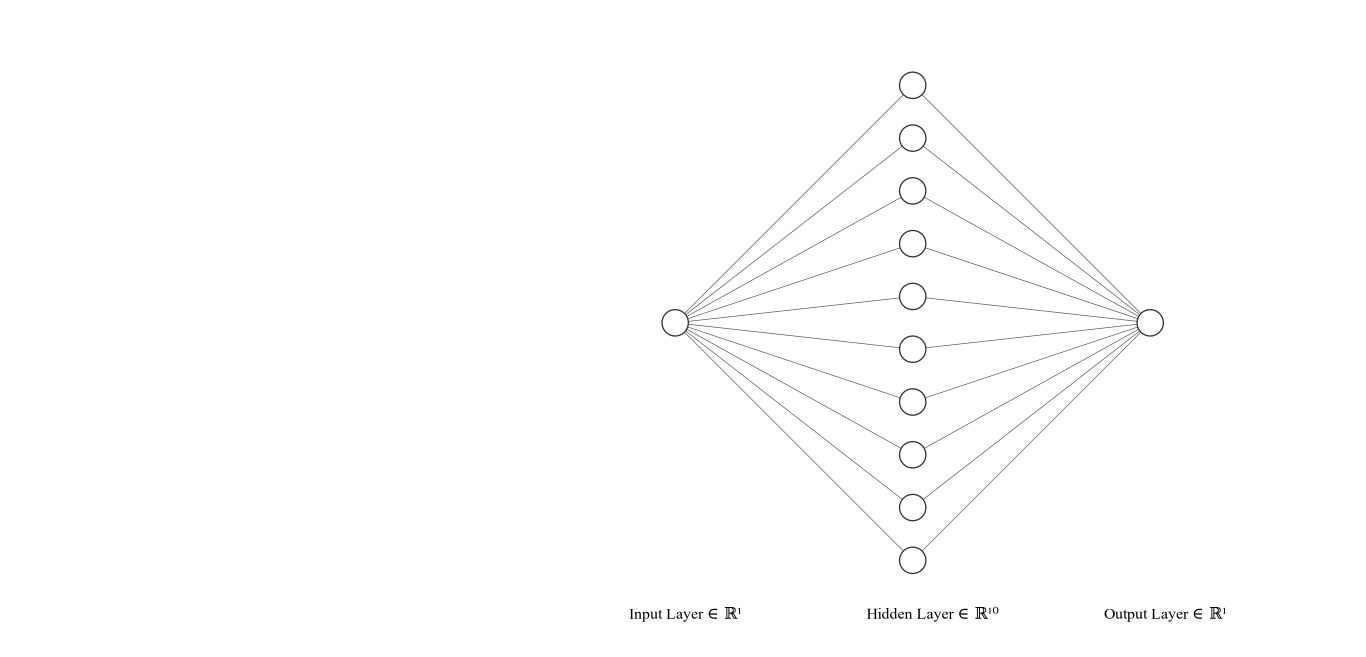

In [ ]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random

In [ ]:
#Define the sigmoid function.
def sigmoid(x):
    return 1./(1. + np.exp(-x))

#From weights and bias (params)and the input (x) compute the output
def f(params, x):
    w0 = params[:10]
    b0 = params[10:20]
    w1 = params[20:30]    
    b1 = params[30]
    x = sigmoid(x*w0 + b0) 
    x = sigmoid(np.sum(x*w1) + b1)
    return x

In [ ]:
#Initialization
key = random.PRNGKey(0) # pseudo-random number generator (PRNG) provided by JAX
params = random.normal(key, shape=(31,))

In [ ]:
# Solving the ODE in the closed interval [-2;2] with the number of time interval:400
inputs = np.linspace(-2., 2., num=401) 
#However, f accepts a single value x as input.
#We could pass it an array but, for differentiation purposes, JAX requires a scalar function, so we must pass a single value as input in order to get a single value as output.
#To efficiently compute f and its derivative dfdx for an array of input values, we vectorize those functions using vmap
#
dfdx = grad(f, 1) #1 means that we want the gradient of f with respect to its second argument x (zero-based indexing)
f_vect = vmap(f, (None, 0)) #(None, 0) specifies that each function is to be mapped over the 0-axis of the second argument (x)
dfdx_vect = vmap(dfdx, (None, 0))


In [ ]:
#Define the loss function following by the ODE and the initial condition.
def loss(params, inputs):
    eq = dfdx_vect(params, inputs) + 2.*inputs*f_vect(params, inputs) # y'-2xy=0
    ic = f(params, 0.) - 1. # y(0)-1=0
    return np.mean(eq**2) + ic**2

In [ ]:
grad_loss = jit(grad(loss, 0)) # JIT (just-in-time compilation) on this function to speed up its execution on accelerator hardware if available.

Remark: Gradient decent with Nesterov momentum
$$\left\{\begin{matrix}
v_{t+1}=\mu v_t -\epsilon \nabla (\theta +\mu v_t)\\ 
\theta_{t+1}=\theta_t+v_{t+1}
\end{matrix}\right.$$

In [ ]:
#Gradient desent with Nesterov momentum
epochs = 1000
learning_rate = 0.1
momentum = 0.99 # Momentum technique
velocity = 0.

for epoch in range(epochs):
    if epoch % 100 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss(params, inputs)))
    gradient = grad_loss(params + momentum*velocity, inputs)
    velocity = momentum*velocity - learning_rate*gradient
    params += velocity

epoch:   0 loss: 0.954726
epoch: 100 loss: 0.061131
epoch: 200 loss: 0.024128
epoch: 300 loss: 0.008868
epoch: 400 loss: 0.003202
epoch: 500 loss: 0.001567
epoch: 600 loss: 0.000880
epoch: 700 loss: 0.000505
epoch: 800 loss: 0.000306
epoch: 900 loss: 0.000224


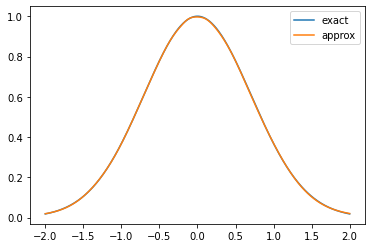

In [ ]:
import matplotlib.pyplot as plt

plt.plot(inputs, np.exp(-inputs**2), label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.show()

**Example 2 :** Let us consider the initial value problem
$$x''(t)=-\frac{1}{4} x(t), \quad t \in [0;4\pi] \\
x(0)=1,x'(0)=0,$$ 

The exact solution for this problem is $x(t) = \cos(x/2)$

In [ ]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

#From weights and bias (params)and the input (x) compute the output
def f(params, x):
    w0 = params[:10]
    b0 = params[10:20]
    w1 = params[20:30]    
    b1 = params[30]
    x = sigmoid(x*w0 + b0) 
    x = sigmoid(np.sum(x*w1) + b1)
    return x
key = random.PRNGKey(0) 
params = random.normal(key, shape=(31,))

inputs = np.linspace(0., 4*np.pi, num=401) 

dfdx = grad(f, 1) 
f_vect = vmap(f, (None, 0)) 
dfdx_vect = vmap(dfdx, (None, 0))
dfdx2 = grad(dfdx,1)
dfdx2_vect = vmap(dfdx2, (None, 0))
def loss(params, inputs):
    eq = dfdx2_vect(params, inputs) +0.25*f_vect(params, inputs) # x''+0.25*x
    ic1 = f(params, 0.) -1 # x(0)=1
    ic2 = dfdx(params, 0.) #x'(0)=0
    return np.mean(eq**2) + (ic1**2+ic2**2)

grad_loss = jit(grad(loss, 0))




In [ ]:
epochs = 1000
learning_rate = 0.001
momentum = 0.99 # Momentum technique
velocity = 0.

for epoch in range(epochs):
    if epoch % 100 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss(params, inputs)))
    gradient = grad_loss(params + momentum*velocity, inputs)
    velocity = momentum*velocity - learning_rate*gradient
    params += velocity

epoch:   0 loss: 0.828414
epoch: 100 loss: 0.191506
epoch: 200 loss: 0.059809
epoch: 300 loss: 0.061791
epoch: 400 loss: 0.062046
epoch: 500 loss: 0.062099
epoch: 600 loss: 0.062102
epoch: 700 loss: 0.062088
epoch: 800 loss: 0.062064
epoch: 900 loss: 0.062034


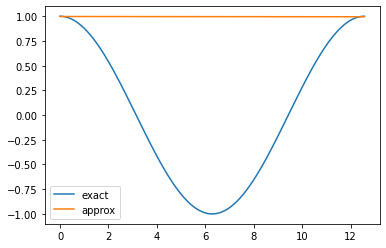

In [ ]:
import matplotlib.pyplot as plt

plt.plot(inputs, np.cos(-inputs/2), label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.show()

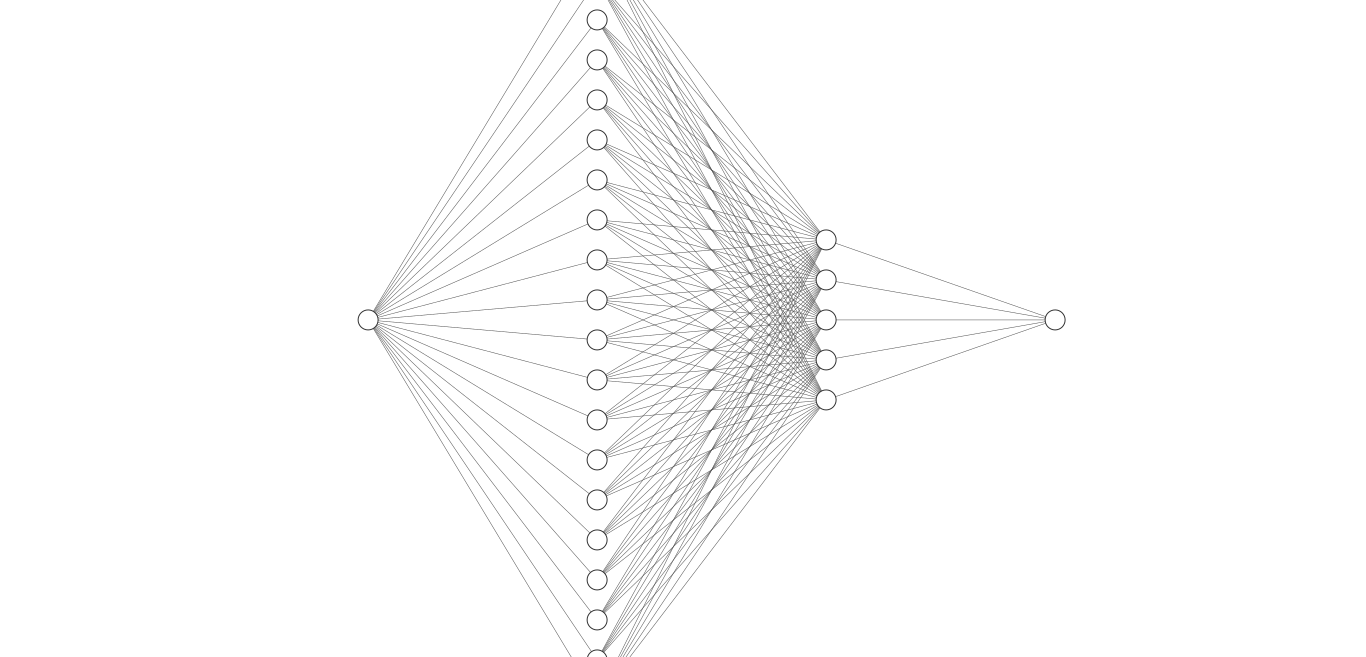

In [ ]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))
def f(params, x):
    w0 = params[:20]
    b0 = params[20:40]
    w1 = params[40:140]
    w1 = np.reshape(w1, (-1, 20))    
    b1 = params[140:145]
    w2 = params[145:150]
    b2 = params[150]
    c1 = sigmoid(x*w0 + b0) 
    c2 = sigmoid(np.dot(w1,c1) + b1)
    c3 = sigmoid(np.sum(c2*w2) + b2)
    return c3

In [ ]:
key = random.PRNGKey(0) 
params = random.normal(key, shape=(31,))

inputs = np.linspace(0., 4*np.pi, num=401) 

dfdx = grad(f, 1) 
f_vect = vmap(f, (None, 0)) 
dfdx_vect = vmap(dfdx, (None, 0))
dfdx2 = grad(dfdx,1)
dfdx2_vect = vmap(dfdx2, (None, 0))
def loss(params, inputs):
    eq = dfdx2_vect(params, inputs) +0.25*f_vect(params, inputs) # x''+0.25*x
    ic1 = f(params, 0.) -1 # x(0)=1
    ic2 = dfdx(params, 0.) #x'(0)=0
    return np.sum(eq**2) + (ic1**2+ic2**2)

grad_loss = jit(grad(loss, 0))


In [ ]:
#Gradient desent with Nesterov momentum
epochs = 1000
learning_rate = 0.1
momentum = 0.99 # Momentum technique
velocity = 0.

for epoch in range(epochs):
    if epoch % 100 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss(params, inputs)))
    gradient = grad_loss(params + momentum*velocity, inputs)
    velocity = momentum*velocity - learning_rate*gradient
    params += velocity

TypeError: ignored